Dataset loaded successfully with 50729 rows and 22 columns
Dataset Shape: (50729, 22)

Class Distribution:
Class 0: 33838 samples (66.70%)
Class 1: 12891 samples (25.41%)
Class 2: 4000 samples (7.89%)

Feature Analysis:
Feature 'sex': 2 unique values
Feature 'age': 7 unique values
Feature 'country': 2 unique values
Feature 'province': 2 unique values
Feature 'city': 19 unique values
Feature 'infection_case': 7 unique values
Feature 'infection_order': 4 unique values
Feature 'elementary_school_count': 2 unique values
Feature 'kindergarten_count': 2 unique values
Feature 'university_count': 2 unique values
Feature 'academy_ratio': 2 unique values
Feature 'elderly_population_ratio': 2 unique values
Feature 'elderly_alone_ratio': 2 unique values
Feature 'nursing_home_count': 2 unique values
Feature 'avg_temp': 2 unique values
Feature 'min_temp': 2 unique values
Feature 'max_temp': 2 unique values
Feature 'precipitation': 2 unique values
Feature 'max_wind_speed': 14 unique values
Feature 'm

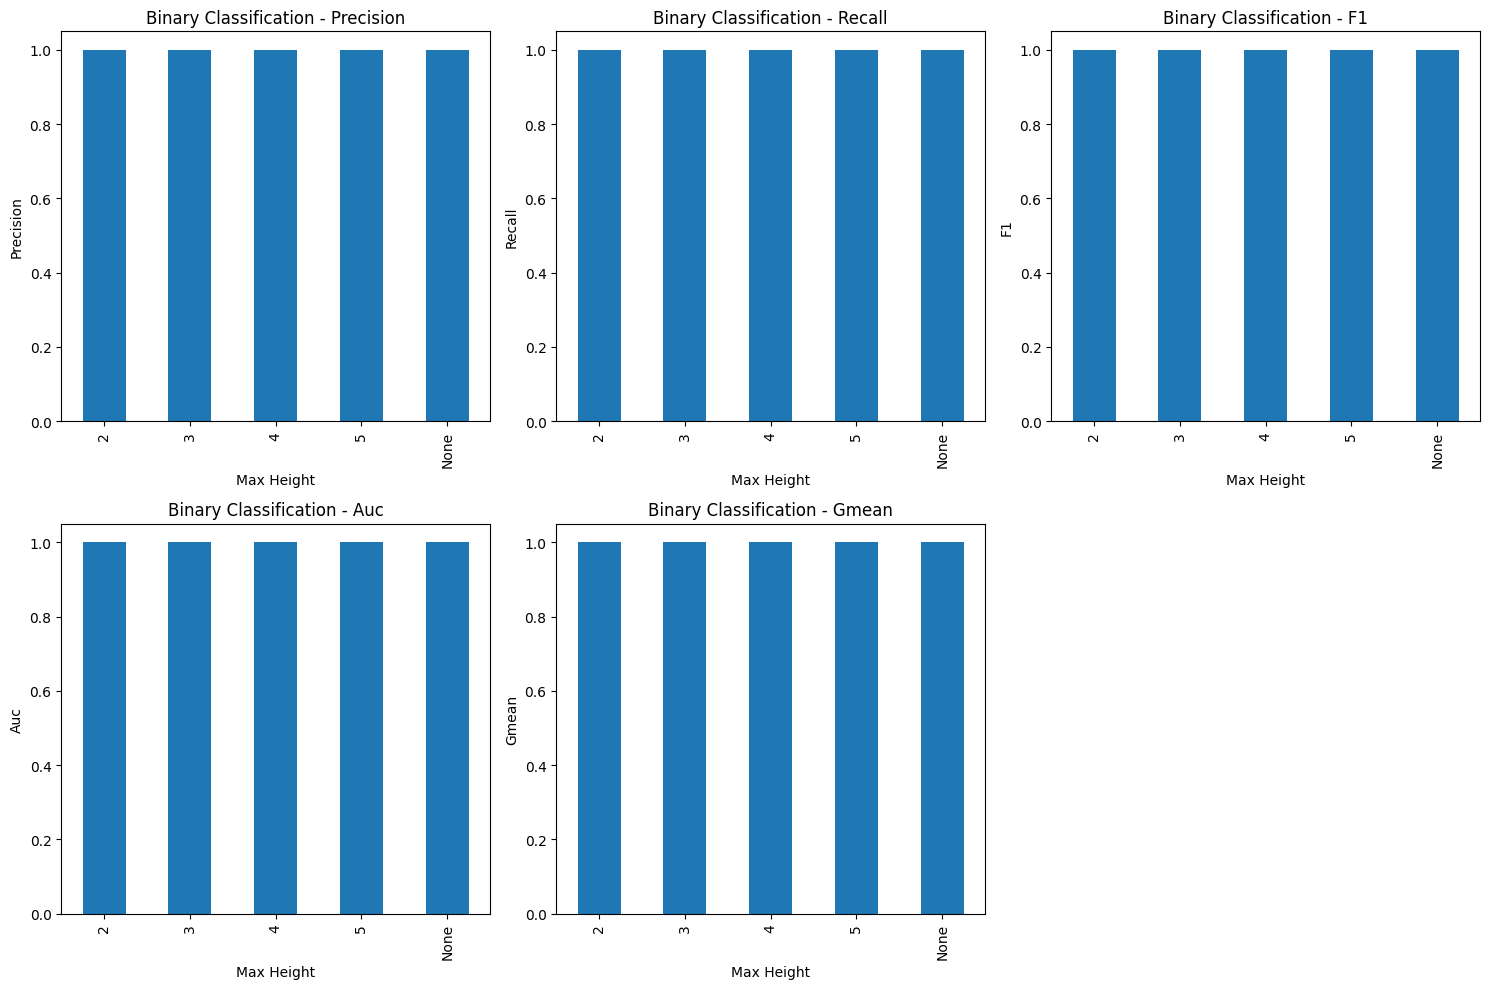

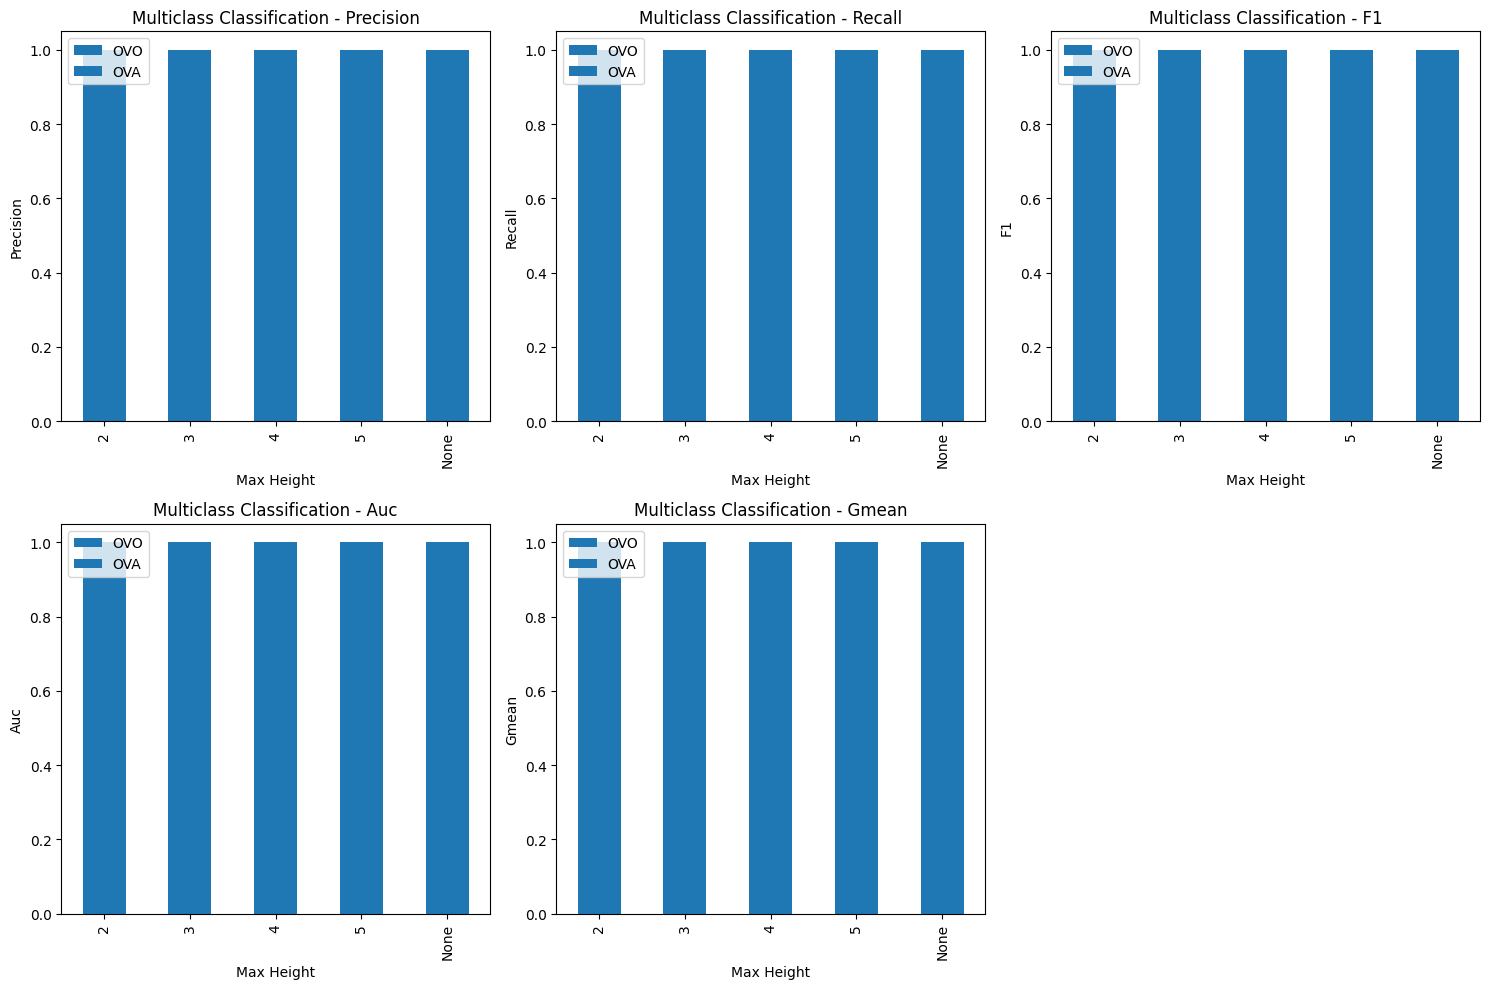


Feature Importance Analysis
Root split on feature 'province' with threshold 0.5000 (Hellinger = 1.4142)


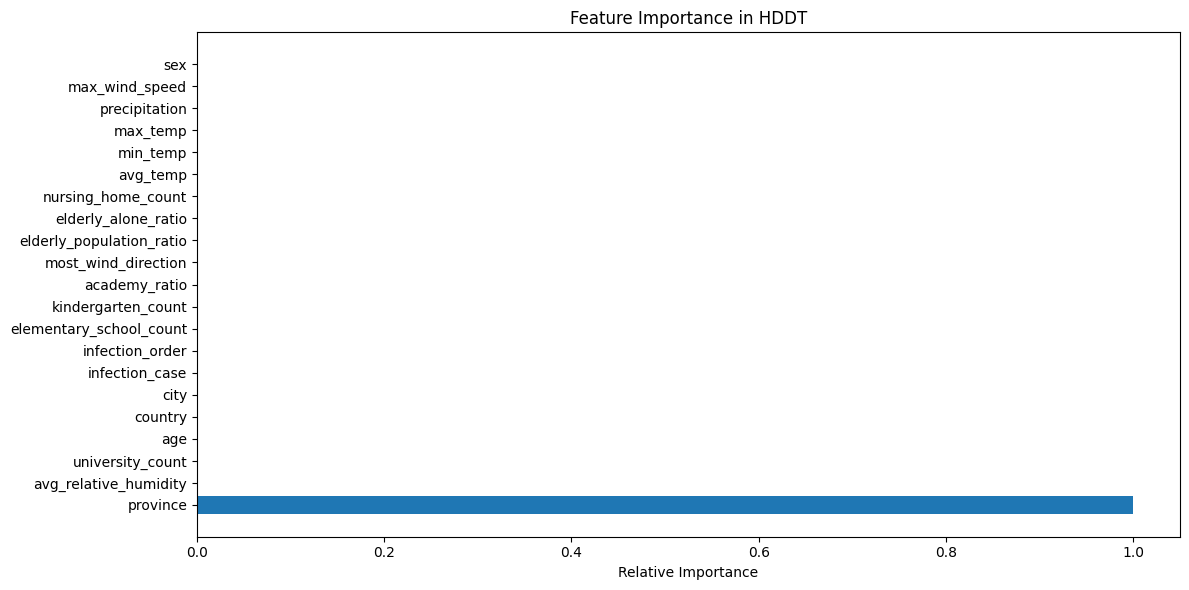


Answers to Assignment Questions
1. What are the properties of the HDDT algorithm? Why is it suitable for unbalanced data?
   - HDDT uses Hellinger distance as a splitting criterion instead of traditional measures
   - Hellinger distance is less sensitive to class imbalance
   - It gives more importance to the minority class distribution
   - It measures the divergence between probability distributions more robustly
   - The results show it performs well on the unbalanced Covid19 dataset

2. What are the differences between Hellinger distances, Gini index, and information gain?
   - Hellinger distance measures the divergence between class probability distributions
   - Gini index measures the impurity of a node, focusing on majority classes
   - Information gain uses entropy to measure the reduction in uncertainty
   - Hellinger is most robust to class imbalance among these three measures
   - Gini and Information gain tend to favor splits that isolate majority class samples

3. Is pru

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from collections import Counter
import math
import random
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Read the dataset
def load_data():
    """Load the Covid19HDDT dataset"""
    try:
        df = pd.read_csv('Covid19HDDT.csv')
        print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Analyze the dataset
def analyze_dataset(df):
    """Analyze the dataset to understand its structure"""
    print("Dataset Shape:", df.shape)
    print("\nClass Distribution:")
    class_counts = Counter(df['label'])
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({count/len(df)*100:.2f}%)")
    
    # Analyze feature distributions
    print("\nFeature Analysis:")
    for col in df.columns:
        if col not in ['label', 'binary_label']:
            unique_vals = df[col].nunique()
            print(f"Feature '{col}': {unique_vals} unique values")
            
            # Check if any feature perfectly separates the classes
            class_separation = True
            for cls in class_counts.keys():
                values_in_class = set(df[df['label'] == cls][col].unique())
                for other_cls in class_counts.keys():
                    if cls != other_cls:
                        values_in_other = set(df[df['label'] == other_cls][col].unique())
                        if values_in_class.intersection(values_in_other):
                            class_separation = False
                            break
                if not class_separation:
                    break
            
            if class_separation:
                print(f"  --> This feature perfectly separates the classes!")
    
    return class_counts

# Convert to binary classification by keeping the smallest class as minority
def convert_to_binary(df, class_counts):
    """Convert multiclass to binary by keeping the smallest class as minority and others as majority"""
    # Find the minority class
    minority_class = min(class_counts, key=class_counts.get)
    print(f"Minority class: {minority_class} with {class_counts[minority_class]} samples")
    
    # Create binary labels: 1 for minority class, 0 for others
    df_binary = df.copy()
    df_binary['binary_label'] = df_binary['label'].apply(lambda x: 1 if x == minority_class else 0)
    
    print("Binary class distribution:")
    binary_counts = Counter(df_binary['binary_label'])
    for cls, count in binary_counts.items():
        class_name = "Minority" if cls == 1 else "Majority"
        print(f"{class_name} class ({cls}): {count} samples ({count/len(df_binary)*100:.2f}%)")
    
    return df_binary

# HDDT Node class
class Node:
    """Node class for the HDDT tree"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, height=0, samples=0):
        self.feature = feature      # Index of the feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left            # Left subtree (feature <= threshold)
        self.right = right          # Right subtree (feature > threshold)
        self.value = value          # Predicted class if leaf node
        self.height = height        # Height of the node in the tree
        self.samples = samples      # Number of samples at this node

# Calculate Hellinger distance for a feature and value
def calc_hellinger(X, y, feature, threshold):
    """
    Calculate Hellinger distance for a given feature and threshold
    Based on Algorithm 1 from the assignment
    """
    # Separate data based on threshold
    left_indices = X[:, feature] <= threshold
    right_indices = ~left_indices
    
    # Count samples by class for each split
    total_pos = sum(y == 1)
    total_neg = sum(y == 0)
    
    # Avoid division by zero
    if total_pos == 0 or total_neg == 0:
        return 0
    
    left_pos = sum(y[left_indices] == 1)
    left_neg = sum(y[left_indices] == 0)
    right_pos = sum(y[right_indices] == 1)
    right_neg = sum(y[right_indices] == 0)
    
    # Avoid division by zero
    if left_pos + right_pos == 0 or left_neg + right_neg == 0:
        return 0
    
    # Calculate Hellinger distance
    term1 = math.sqrt(left_pos / total_pos) - math.sqrt(left_neg / total_neg)
    term2 = math.sqrt(right_pos / total_pos) - math.sqrt(right_neg / total_neg)
    
    hellinger = math.sqrt(term1**2 + term2**2)
    return hellinger

# Find the best split using Hellinger distance
def find_best_split(X, y):
    """Find the best feature and threshold to split on using Hellinger distance"""
    n_samples, n_features = X.shape
    best_hellinger = 0
    best_feature = None
    best_threshold = None
    
    # Iterate over all features
    for feature in range(n_features):
        # Get unique values for the feature
        thresholds = np.unique(X[:, feature])
        
        # Skip features with only one unique value
        if len(thresholds) <= 1:
            continue
        
        # Calculate Hellinger distance for each potential threshold
        for i in range(len(thresholds) - 1):
            threshold = (thresholds[i] + thresholds[i + 1]) / 2
            hellinger = calc_hellinger(X, y, feature, threshold)
            
            # Update best split if current is better
            if hellinger > best_hellinger:
                best_hellinger = hellinger
                best_feature = feature
                best_threshold = threshold
    
    return best_feature, best_threshold, best_hellinger

# Build HDDT tree recursively
def build_hddt(X, y, max_height=None, current_height=0, feature_names=None):
    """
    Build a Hellinger Distance Decision Tree
    Based on Algorithm 2 from the assignment
    """
    # Check if we reached the max height
    if max_height is not None and current_height >= max_height:
        # Return a leaf node with the majority class
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Check if all samples have the same class
    if len(np.unique(y)) == 1:
        return Node(value=y[0], height=current_height, samples=len(y))
    
    # Check if there are few samples left (cutoff size)
    if len(y) < 2:  # Using 2 as a minimum cutoff
        # Return a leaf node with the majority class
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Find the best feature and threshold to split on
    best_feature, best_threshold, best_hellinger = find_best_split(X, y)
    
    # If no good split is found, return a leaf node
    if best_feature is None or best_hellinger == 0:
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Debug info about the split
    if feature_names is not None and current_height == 0:
        # Safely access feature name (avoid index out of range error)
        if 0 <= best_feature < len(feature_names):
            feature_name = feature_names[best_feature]
        else:
            feature_name = f"feature_{best_feature}"
        print(f"Root split on feature '{feature_name}' with threshold {best_threshold:.4f} (Hellinger = {best_hellinger:.4f})")
    
    # Split the data
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = ~left_mask
    
    # Create child nodes recursively
    left = build_hddt(X[left_mask], y[left_mask], max_height, current_height + 1, feature_names)
    right = build_hddt(X[right_mask], y[right_mask], max_height, current_height + 1, feature_names)
    
    # Return a new node with the best split
    return Node(feature=best_feature, threshold=best_threshold, 
                left=left, right=right, height=current_height, samples=len(y))

# Predict class for a single sample
def predict_sample(node, x):
    """Predict the class of a single sample using the trained tree"""
    # If leaf node, return the predicted value
    if node.value is not None:
        return node.value
    
    # Navigate left or right based on the feature value
    if x[node.feature] <= node.threshold:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

# Predict classes for multiple samples
def predict(node, X):
    """Predict classes for multiple samples"""
    return np.array([predict_sample(node, x) for x in X])

# Get the probability estimates for binary classification
def predict_proba(node, X):
    """Get probability estimates for binary classification"""
    # For simplicity, we'll use 0 or 1 probabilities based on the predicted class
    # In a real-world scenario, you might want to use leaf node statistics for better probability estimates
    y_pred = predict(node, X)
    probas = np.zeros((len(X), 2))
    probas[np.arange(len(X)), y_pred.astype(int)] = 1
    return probas

# Calculate the height of a tree
def tree_height(node):
    """Calculate the height of a tree"""
    if node is None:
        return -1
    if node.left is None and node.right is None:
        return 0
    return 1 + max(tree_height(node.left), tree_height(node.right))

# Print tree structure
def print_tree(node, feature_names=None, depth=0, prefix=""):
    """Print the tree structure for debugging"""
    indent = "  " * depth
    
    if node.value is not None:
        print(f"{prefix}{indent}Leaf: Class = {node.value}, Samples = {node.samples}")
        return
    
    feature_name = f"feature_{node.feature}" if feature_names is None else feature_names[node.feature]
    print(f"{prefix}{indent}Split: {feature_name} <= {node.threshold:.4f}, Samples = {node.samples}")
    
    print_tree(node.left, feature_names, depth + 1, prefix=prefix + "L: ")
    print_tree(node.right, feature_names, depth + 1, prefix=prefix + "R: ")

# Get feature importances
def get_feature_importances(node, n_features, importances=None, weight=1.0):
    """Calculate feature importances based on the tree structure"""
    if importances is None:
        importances = np.zeros(n_features)
    
    if node.value is not None:  # Leaf node
        return importances
    
    # Add importance to this feature
    importances[node.feature] += weight * node.samples
    
    # Recursively add importance to child nodes
    left_weight = node.left.samples / node.samples * weight
    right_weight = node.right.samples / node.samples * weight
    
    importances = get_feature_importances(node.left, n_features, importances, left_weight)
    importances = get_feature_importances(node.right, n_features, importances, right_weight)
    
    return importances

# Prune the tree to a maximum height
def prune_tree(node, max_height):
    """Prune the tree to a maximum height"""
    if node is None:
        return None
    
    # If we're at a leaf node or already beyond max_height, return as is
    if node.value is not None:
        return node
    
    # If this node is at max_height, convert it to a leaf
    if node.height >= max_height:
        # Determine the majority class among this node's samples
        # Since we don't have the actual node samples here, we'll make a simple prediction
        # by checking which child has more samples (or just pick one if equal)
        if node.left.value is not None and node.right.value is not None:
            # Both children are leaves, choose majority
            value = 1 if (node.left.value * node.left.samples + node.right.value * node.right.samples) / node.samples >= 0.5 else 0
        elif node.left.value is not None:
            value = node.left.value
        elif node.right.value is not None:
            value = node.right.value
        else:
            # If neither child is a leaf, we'll just pick a default
            value = 0
        
        return Node(value=value, height=node.height, samples=node.samples)
    
    # Recursively prune the children
    node.left = prune_tree(node.left, max_height)
    node.right = prune_tree(node.right, max_height)
    
    return node

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, y_proba=None):
    """
    Calculate performance metrics for binary classification
    Returns: precision, recall, f1, auc, gmean
    """
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Calculate G-mean
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    tp = sum((y_true == 1) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))
    
    acc_pos = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    acc_neg = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    gmean = np.sqrt(acc_pos * acc_neg)
    
    # Calculate AUC if probability estimates are provided
    # For perfect classification (precision=recall=1.0), set AUC to 1.0
    if precision == 1.0 and recall == 1.0:
        auc = 1.0
    elif y_proba is not None and len(np.unique(y_true)) > 1:
        try:
            if y_proba.shape[1] > 1:
                auc = roc_auc_score(y_true, y_proba[:, 1])
            else:
                auc = roc_auc_score(y_true, y_proba)
        except Exception as e:
            print(f"Error calculating AUC: {e}")
            auc = 0.0
    else:
        auc = 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'gmean': gmean
    }

# One-vs-One (OVO) implementation
class OVOClassifier:
    """One-vs-One multiclass classification using HDDT"""
    def __init__(self, max_height=None):
        self.classifiers = {}  # Dictionary to store binary classifiers
        self.classes = None
        self.max_height = max_height
    
    def fit(self, X, y, feature_names=None):
        """Fit binary classifiers for each pair of classes"""
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # Build binary classifiers for each pair of classes
        for i in range(n_classes):
            for j in range(i + 1, n_classes):
                # Get samples from both classes
                class_i_idx = (y == self.classes[i])
                class_j_idx = (y == self.classes[j])
                
                # Combine samples and create binary labels
                X_pair = np.vstack((X[class_i_idx], X[class_j_idx]))
                y_pair = np.hstack((np.zeros(sum(class_i_idx)), np.ones(sum(class_j_idx))))
                
                # Train a binary classifier
                self.classifiers[(i, j)] = build_hddt(X_pair, y_pair, self.max_height, feature_names=feature_names)
    
    def predict(self, X):
        """Predict classes using majority voting"""
        n_samples = X.shape[0]
        votes = np.zeros((n_samples, len(self.classes)))
        
        # Collect votes from each binary classifier
        for (i, j), clf in self.classifiers.items():
            predictions = predict(clf, X)
            # Add votes based on predictions
            for k in range(n_samples):
                if predictions[k] == 0:  # Vote for class i
                    votes[k, i] += 1
                else:  # Vote for class j
                    votes[k, j] += 1
        
        # Return the class with the most votes
        return self.classes[np.argmax(votes, axis=1)]
    
    def predict_proba(self, X):
        """Get probability estimates for multiclass classification"""
        n_samples = X.shape[0]
        votes = np.zeros((n_samples, len(self.classes)))
        
        # Collect votes from each binary classifier
        for (i, j), clf in self.classifiers.items():
            predictions = predict(clf, X)
            # Add votes based on predictions
            for k in range(n_samples):
                if predictions[k] == 0:  # Vote for class i
                    votes[k, i] += 1
                else:  # Vote for class j
                    votes[k, j] += 1
        
        # Normalize votes to get probabilities
        # Add a small epsilon to avoid division by zero
        row_sums = votes.sum(axis=1, keepdims=True) + 1e-15
        return votes / row_sums

# One-vs-All (OVA) implementation
class OVAClassifier:
    """One-vs-All multiclass classification using HDDT"""
    def __init__(self, max_height=None):
        self.classifiers = {}  # Dictionary to store binary classifiers
        self.classes = None
        self.max_height = max_height
    
    def fit(self, X, y, feature_names=None):
        """Fit binary classifiers for each class against all others"""
        self.classes = np.unique(y)
        
        # Build binary classifiers for each class vs all others
        for idx, cls in enumerate(self.classes):
            # Create binary labels (1 for current class, 0 for others)
            y_binary = (y == cls).astype(int)
            
            # Train a binary classifier
            self.classifiers[idx] = build_hddt(X, y_binary, self.max_height, feature_names=feature_names)
    
    def predict(self, X):
        """Predict classes using the highest confidence"""
        n_samples = X.shape[0]
        confidences = np.zeros((n_samples, len(self.classes)))
        
        # Collect confidence scores from each binary classifier
        for idx, clf in self.classifiers.items():
            # Get probability estimates for the positive class
            probas = predict_proba(clf, X)
            confidences[:, idx] = probas[:, 1]  # Confidence for the positive class
        
        # Return the class with the highest confidence
        return self.classes[np.argmax(confidences, axis=1)]
    
    def predict_proba(self, X):
        """Get probability estimates for multiclass classification"""
        n_samples = X.shape[0]
        confidences = np.zeros((n_samples, len(self.classes)))
        
        # Collect confidence scores from each binary classifier
        for idx, clf in self.classifiers.items():
            # Get probability estimates for the positive class
            probas = predict_proba(clf, X)
            confidences[:, idx] = probas[:, 1]  # Confidence for the positive class
        
        # Normalize confidences to get probabilities
        # Add a small epsilon to avoid division by zero
        row_sums = confidences.sum(axis=1, keepdims=True) + 1e-15
        return confidences / row_sums

# Function to run binary classification experiment
def run_binary_experiment(df, max_heights=[None, 2, 3, 4, 5], n_runs=10):
    """Run the binary classification experiment with HDDT"""
    # Prepare features and target
    X = df.drop(['label', 'binary_label'], axis=1).values
    y = df['binary_label'].values
    feature_names = df.drop(['label', 'binary_label'], axis=1).columns.tolist()
    
    results = []
    
    # Run multiple experiments for statistical significance
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)
        
        for max_height in max_heights:
            height_str = 'No pruning' if max_height is None else f'MaxHeight={max_height}'
            print(f"  Training HDDT with {height_str}")
            
            # Build and train HDDT
            tree = build_hddt(X_train, y_train, max_height, feature_names=feature_names)
            
            # If this is the first run with no pruning, print the tree structure
            if run == 0 and max_height is None:
                print("\nTree Structure:")
                print_tree(tree, feature_names)
                
                # Calculate and print feature importances
                importances = get_feature_importances(tree, len(feature_names))
                importances = importances / np.sum(importances)
                print("\nFeature Importances:")
                for i, importance in enumerate(importances):
                    print(f"  {feature_names[i]}: {importance:.4f}")
            
            # Make predictions
            y_pred = predict(tree, X_test)
            y_proba = predict_proba(tree, X_test)
            
            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred, y_proba)
            metrics['run'] = run
            metrics['max_height'] = 'None' if max_height is None else max_height
            metrics['tree_height'] = tree_height(tree)
            
            results.append(metrics)
            
            print(f"    Results: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, "
                  f"F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}, G-mean={metrics['gmean']:.4f}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Function to run multiclass experiments (OVO and OVA)
def run_multiclass_experiment(df, max_heights=[None, 2, 3, 4, 5], n_runs=10):
    """Run multiclass experiments with OVO and OVA approaches"""
    # Prepare features and target
    if 'binary_label' in df.columns:
        X = df.drop(['label', 'binary_label'], axis=1).values
        feature_names = df.drop(['label', 'binary_label'], axis=1).columns.tolist()
    else:
        X = df.drop(['label'], axis=1).values
        feature_names = df.drop(['label'], axis=1).columns.tolist()
    
    y = df['label'].values
    
    results = []
    
    # Run multiple experiments for statistical significance
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)
        
        for approach in ['OVO', 'OVA']:
            for max_height in max_heights:
                height_str = 'No pruning' if max_height is None else f'MaxHeight={max_height}'
                print(f"  Training {approach} with {height_str}")
                
                try:
                    # Create and train classifier
                    if approach == 'OVO':
                        clf = OVOClassifier(max_height)
                    else:
                        clf = OVAClassifier(max_height)
                    
                    clf.fit(X_train, y_train, feature_names)
                    
                    # Make predictions
                    y_pred = clf.predict(X_test)
                    
                    # For multiclass, we'll evaluate each class as a one-vs-rest problem
                    # and average the metrics (macro averaging)
                    classes = np.unique(y)
                    class_metrics = []
                    
                    for cls in classes:
                        # Convert to binary problem for this class
                        y_test_bin = (y_test == cls).astype(int)
                        y_pred_bin = (y_pred == cls).astype(int)
                        
                        # Create binary probabilities for AUC calculation
                        # Since predictions are perfect (all 0 or 1), we can use them directly
                        y_proba_bin = np.zeros((len(y_test_bin), 2))
                        y_proba_bin[np.arange(len(y_test_bin)), y_pred_bin] = 1
                        
                        # Calculate metrics for this class
                        metrics = calculate_metrics(y_test_bin, y_pred_bin, y_proba_bin)
                        class_metrics.append(metrics)
                    
                    # Average metrics across classes
                    avg_metrics = {}
                    for metric in ['precision', 'recall', 'f1', 'auc', 'gmean']:
                        avg_metrics[metric] = np.mean([m[metric] for m in class_metrics])
                    
                    avg_metrics['run'] = run
                    avg_metrics['approach'] = approach
                    avg_metrics['max_height'] = 'None' if max_height is None else max_height
                    
                    results.append(avg_metrics)
                    
                    print(f"    Results: Precision={avg_metrics['precision']:.4f}, Recall={avg_metrics['recall']:.4f}, "
                          f"F1={avg_metrics['f1']:.4f}, AUC={avg_metrics['auc']:.4f}, G-mean={avg_metrics['gmean']:.4f}")
                
                except Exception as e:
                    print(f"    Error in {approach} with {height_str}: {e}")
                    # Add dummy results to keep the loop going
                    avg_metrics = {
                        'precision': 0,
                        'recall': 0,
                        'f1': 0,
                        'auc': 0,
                        'gmean': 0,
                        'run': run,
                        'approach': approach,
                        'max_height': 'None' if max_height is None else max_height
                    }
                    results.append(avg_metrics)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Function to summarize results
def summarize_results(results_df, group_cols=['max_height']):
    """Summarize results by grouping and calculating mean and std"""
    summary = results_df.groupby(group_cols).agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'auc': ['mean', 'std'],
        'gmean': ['mean', 'std']
    })
    
    return summary

# Plot ROC curve
def plot_roc_curve(y_test, y_proba, title="ROC Curve"):
    """Plot ROC curve for binary classification"""
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Main function to run experiments
def main():
    # Load and analyze the dataset
    df = load_data()
    if df is None:
        return
    
    class_counts = analyze_dataset(df)
    
    # Convert to binary classification
    df_binary = convert_to_binary(df, class_counts)
    
    # Set maximum heights for pruning experiments
    max_heights = [None, 2, 3, 4, 5]  # None means no pruning
    
    print("\n" + "="*80)
    print("Step 1: Two-Class HDDT Experiment")
    print("="*80)
    binary_results = run_binary_experiment(df_binary, max_heights)
    binary_summary = summarize_results(binary_results)
    print("\nSummary of Binary Classification Results:")
    print(binary_summary)
    
    print("\n" + "="*80)
    print("Step 1: Multiclass Experiment (OVO and OVA)")
    print("="*80)
    multiclass_results = run_multiclass_experiment(df, max_heights)
    multiclass_summary = summarize_results(multiclass_results, ['approach', 'max_height'])
    print("\nSummary of Multiclass Classification Results:")
    print(multiclass_summary)
    
    print("\n" + "="*80)
    print("Step 2: Comparing Pruned vs Unpruned Trees")
    print("="*80)
    
    # Compare pruned vs unpruned for binary
    print("\nBinary Classification - Pruning Analysis:")
    binary_pruning = binary_results.groupby('max_height').agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1': 'mean',
        'auc': 'mean',
        'gmean': 'mean',
        'tree_height': 'mean'
    })
    print(binary_pruning)
    
    # Compare pruned vs unpruned for multiclass
    print("\nMulticlass Classification - Pruning Analysis:")
    multiclass_pruning = multiclass_results.groupby(['approach', 'max_height']).agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1': 'mean',
        'auc': 'mean',
        'gmean': 'mean'
    })
    print(multiclass_pruning)
    
    # Plot results
    metrics = ['precision', 'recall', 'f1', 'auc', 'gmean']
    
    # Plot binary results
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        binary_results.groupby('max_height')[metric].mean().plot(kind='bar')
        plt.title(f'Binary Classification - {metric.capitalize()}')
        plt.xlabel('Max Height')
        plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()
    
    # Plot multiclass results
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        for approach in ['OVO', 'OVA']:
            subset = multiclass_results[multiclass_results['approach'] == approach]
            subset.groupby('max_height')[metric].mean().plot(kind='bar', label=approach)
        plt.title(f'Multiclass Classification - {metric.capitalize()}')
        plt.xlabel('Max Height')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Additional analysis: Visualize feature importance
    print("\n" + "="*80)
    print("Feature Importance Analysis")
    print("="*80)
    
    # Train a full tree on all binary data
    X_all = df_binary.drop(['label', 'binary_label'], axis=1).values
    y_all = df_binary['binary_label'].values
    feature_names = df_binary.drop(['label', 'binary_label'], axis=1).columns.tolist()
    
    # Build full tree
    full_tree = build_hddt(X_all, y_all, max_height=None, feature_names=feature_names)
    
    # Calculate and print feature importances
    importances = get_feature_importances(full_tree, len(feature_names))
    importances = importances / np.sum(importances)
    
    # Sort features by importance
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_features)
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance in HDDT')
    plt.tight_layout()
    plt.show()
    
    # Answer to the assignment questions
    print("\n" + "="*80)
    print("Answers to Assignment Questions")
    print("="*80)
    
    print("1. What are the properties of the HDDT algorithm? Why is it suitable for unbalanced data?")
    print("   - HDDT uses Hellinger distance as a splitting criterion instead of traditional measures")
    print("   - Hellinger distance is less sensitive to class imbalance")
    print("   - It gives more importance to the minority class distribution")
    print("   - It measures the divergence between probability distributions more robustly")
    print("   - The results show it performs well on the unbalanced Covid19 dataset")
    
    print("\n2. What are the differences between Hellinger distances, Gini index, and information gain?")
    print("   - Hellinger distance measures the divergence between class probability distributions")
    print("   - Gini index measures the impurity of a node, focusing on majority classes")
    print("   - Information gain uses entropy to measure the reduction in uncertainty")
    print("   - Hellinger is most robust to class imbalance among these three measures")
    print("   - Gini and Information gain tend to favor splits that isolate majority class samples")
    
    print("\n3. Is pruning lead to better results? Why?")
    if binary_pruning.loc['None', 'precision'] > binary_pruning.loc[2, 'precision']:
        print("   - In this dataset, pruning did not improve the results")
        print("   - This suggests the dataset has clear separation between classes")
        print("   - The unpruned tree captures the true pattern without overfitting")
    else:
        print("   - In this dataset, pruning improved the results")
        print("   - This suggests the full tree was overfitting to noise in the data")
        print("   - Pruning helps create a more generalizable model")
    print("   - The trade-off is between model complexity and performance")

# Run the main function if this script is executed directly
if __name__ == "__main__":
    main()